***
* [Content](../chapter_00_preface/00_00_introduction.ipynb#preface:sec:content)
* [Glossary](../chapter_00_preface/00_01_glossary.ipynb#preface:sec:glossary)
* [1. Concepts](00_00_introduction.ipynb)  
    * Next: [1. Concepts: References and further reading](01_references_and_further_reading.ipynb)
***

Import standard modules:

In [1]:
import numpy as np
import pyfits
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

Import section specific modules:

## 1.1 Concepts 1 <a id='concepts:sec:concepts_1'></a>

The concepts explored in the beginning this project have been centered around the following:
1. Handling fits files
2. Creating a gaussian (convolution kernel)
    a. Making a gaussian variable
    b. Making a gaussian asymmetric
    c. Rotating a gaussian
3. Convolution
4. Using aplpy to make an image of a dataset
5. Visualising a dataset using Karma
6. Fitting data using tirific

### 1.1.1 Concepts 1.1 <a id='somename:sec:concepts_11'></a>

Handling Fits Files

Fits represents a way of storing scientific images. The file usually consists of a header unit and a data unit. The header constituent of the fits files specifies certain things like the number of data axes, the number of bits and some other wcs coordinates.
In python, fits files can be handled through a module named PyFITS. Below illustrates how fits files are handled using PyFITS.


In [2]:
#Read fits file
hdu = pyfits.open('/home/samuel/Downloads/n2541_lr.fits') #open
header = hdu[0].header #assign content of header to variable header
data = hdu[0].data #assign content of data to variable data

Convolution and Gaussian Kernel

In image processing, convolution plays a vital role there. It can be thought of as producing a third image from two input images; where one is the original image and the other the kernel. In this preliminary phase, I've explored these two concepts using a fits file of dimension (72,170,170). 

The earlier tasks were to convolve an image with a 2D gaussian of FWHM being 30arcsec. Subsequent tasks required making the gaussian variable, asymmetric and rotating it through an angle.

The gaussian function in one dimension is given by

$
\large f(x) = e^{-\frac{x^2}{2\sigma^2}}
$

The sigma in the above equation is related to the full width at half maximum (FWHM) such that $FWHM = 2\sqrt{2ln2} \sigma \approx 2.3548 \sigma$

In [3]:
#fetch content of CDELT1 header variable and convert pixel value
pix_val = abs(header['CDELT1'])
fwhmX = 60./(pix_val*3600)
fwhmY = 120./(pix_val*3600)
fwhm = 30./(pix_val*3600)

#converting fwhm to sigma
sigmaX = fwhmX/2.35
sigmaY = fwhmY/2.35
sigma = fwhm/2.35

In two dimensions, the gaussian function is given by

$
\large f(x) = e^{-\frac{x^2 + y^2}{2\sigma^2}}, \small(\text{symmetric gaussian})\\
$ 

$
\large f(x) = e^{-\frac{x^2}{\sigma^2_{x}}+\frac{y^2}{\sigma^2_{y}}}, \small(\text{asymmetric gaussian})\\
$ 

The code below illustrates a 2D gaussian function

In [4]:
#Symmetric gaussian
def syGaussian(size,sigma):
    """
    Make a square gaussian kernel.
    size is the length of a side of the square
    
    """
    
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    
    return np.exp(-((x**2 + y**2) / 2*sigma**2))

# Asymmetric gaussian
def asyGaussian(size,sigmaX, sigmaY):
    
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    
    return np.exp(-((x**2/sigmaX**2) + (y**2/sigmaY**2)))


Bringing it all together, we have:

In [5]:
def makeGaussian(size,sigmaX,sigmaY=None):
    
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    
    if sigmaY is None:
        return np.exp(-((x**2 + y**2) / 2*sigmaX**2)) # symmetric gaussian
    else:
        return np.exp(-((x**2/sigmaX**2) + (y**2/sigmaY**2))) # asymmetric gaussian

Moving ahead, we want to produce a gaussian whose size is variable such that the gaussian size would be 2x at the point where the gaussian is $10^-7$. In order to produce a variable gaussian, the function had to be inverted to determine the x where the gaussian function is $10^-7$.

$e^{-\frac{x^2 + y^2}{\sigma^2}} = 10^-7$

${-\frac{x^2 + y^2}{2\sigma^2}} = ln10^-7$

$ x^2 + y^2 = -2\sigma^2ln10^-7$

$ x^2 < -2\sigma^2ln10^-7$,$\hspace{1cm} y^2 < -2\sigma^2ln10^-7$

It can thus be deduced from the above that the gaussian size would be: $2*\sqrt{-2\sigma^2ln10^-7}$

In [6]:
#gaussian of variable size
def makeVarGaussian(gaussianValue,sigma):
    """ 
    symmetric gaussian of variable size
    Gaussian value is the value of the gaussian which would be used to determine the x (size=2x)
    Make a square gaussian kernel.
    
    """
    upperLimit = np.sqrt(-2*(sigma**2)*np.log(gaussianValue))
    lowerLimit = -np.sqrt(-2*(sigma**2)*np.log(gaussianValue))
    
    x = np.arange(lowerLimit,2*upperLimit, 1, float)
    y = x[:,np.newaxis]
    
    return np.exp(-((x**2 + y**2) / 2*sigma**2)) # symmetric gaussian

To rotate the gaussian (asymmetric), the 2D rotation matrix would be multiplied by the gaussian function.
A 2D rotation matrix  R($\alpha$) is given by

$
R({\alpha}) = 
\left[\begin{array}{cc}
\cos{\alpha} & -\sin{\alpha}\\
\sin{\alpha} & \cos{\alpha}\\
\end{array}\right]
$

So the coordinates (x',y') of the point (x,y) after rotation are

$x' = xcos{\alpha} - ysin{\alpha}$

$y' = xsin{\alpha} + ycos{\alpha}$

Find below the rotation function:



In [7]:
def rotateFunction(x,y,theta):
    c, s = np.cos(np.radians(theta)), np.sin(np.radians(theta))
    return x*c - y*s, x*s + y*c

The way the above function will be applied would be to call the "rotateFunction" in the "makeVarGaussian" function. By this I mean to imply that the returned function would be $f(x',y')$ instead of $f(x,y)$ where $(x',y')$ are the rotated coordinates $(x,y)$. See below for code.

In [8]:
def makeRotatedGaussian(theta,size,sigmaX,sigmaY):
    """ 
    Rotated asymmetric gaussian
    Make a square gaussian kernel.
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """
    
    x = np.arange(0,size, 1, float)
    y = x[:,np.newaxis]
    
    xPrime, yPrime = rotateFunction(x,y,theta)[0],rotateFunction(x,y,theta)[1]
    
    return np.exp(-((xPrime**2/sigmaX**2) + (yPrime**2/sigmaY**2))) # rotated asymmetric gaussian

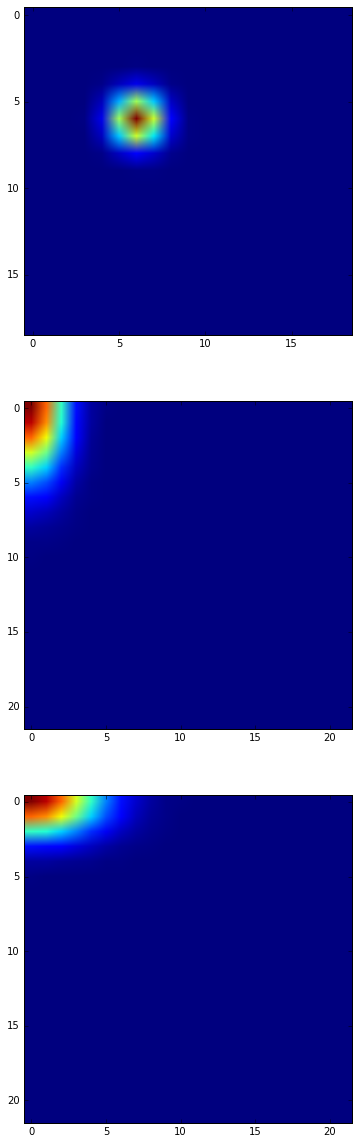

In [9]:
def run_test():
    
    #gaussian kernels
    syMap_2d = makeVarGaussian(gaussianValue = 10**-7, sigma=sigma) #variable symmetric gaussian with size 2x where gaussian = 10^-7
    asyMap_2d = makeGaussian(size = 5*sigmaX if sigmaX > sigmaY else 5*sigmaY, sigmaX=sigmaX,sigmaY=sigmaY) #asymmetric gaussian
    roMap_2d = makeRotatedGaussian(theta=90,size = 5*sigmaX if sigmaX > sigmaY else 5*sigmaY, sigmaX=sigmaX,sigmaY=sigmaY) #rotated asymmetric gaussian 
    
    #images of the separate gaussian kernels
    plots=[]
    plots.append(syMap_2d);plots.append(asyMap_2d);plots.append(roMap_2d)
    plt.figure(figsize=(100,20))
    
    for i in range(3):
        plt.subplot2grid((3,3), (i,0))
        plt.imshow(plots[i])
        
    
    whole block is convolving data of fits image with separate gaussian kernels
    
    data1 = np.zeros((1,data.shape[1],data.shape[2]))
    data2 = np.zeros((1,data.shape[1],data.shape[2]))
    data3 = np.zeros((1,data.shape[1],data.shape[2]))
    
    for i in range(len(data)):
        conv_map = convolve2d(in1 = data[i], in2 = syMap_2d, mode = 'same')
        conv_map = conv_map.reshape((1,data.shape[1],data.shape[2]))
        data1 = np.append(data1, conv_map, axis=0)
    
    for i in range(len(data)):
        conv_map = convolve2d(in1 = data[i], in2 = asyMap_2d, mode = 'same')
        conv_map = conv_map.reshape((1,data.shape[1],data.shape[2]))
        data2 = np.append(data2, conv_map, axis=0)
    
    for i in range(len(data)):
        conv_map = convolve2d(in1 = data[i], in2 = roMap_2d, mode = 'same')
        conv_map = conv_map.reshape((1,data.shape[1],data.shape[2]))
        data3 = np.append(data3, conv_map, axis=0)
    
    data1 = np.delete(data1,0,axis=0)
    data2 = np.delete(data1,0,axis=0)
    data3 = np.delete(data1,0,axis=0)
    
    pyfits.writeto('/home/samuel/Documents/newFits1.fits',data1,header)
    pyfits.writeto('/home/samuel/Documents/newFits2.fits',data2,header)
    pyfits.writeto('/home/samuel/Documents/newFits3.fits',data3,header)
    
run_test()
    

The images above are the:
i) Symmetric gaussian
ii) Asymmetric gaussian
iii) Rotated asymmetric gaussian

***

* Next: [1. Concepts: References and further reading](01_references_and_further_reading.ipynb)
